## Rate plots down currents. Several iterations with final rate+CI error bar plots at the bottom

In [1]:
# %matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

OUTPATH = './output'
IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

## Loading Data and Indicators

In [2]:
obs = pd.read_csv(IOPATH)
for col, count in obs.count().items():
    print(f"{col}: {count} non-NaN values")
obs

Unnamed: 0.1: 1378653 non-NaN values
Unnamed: 0: 1378653 non-NaN values
time: 1378653 non-NaN values
longitude (degrees_east): 1378653 non-NaN values
latitude (degrees_north): 1378653 non-NaN values
depth (m): 1378653 non-NaN values
pressure (dbar): 1378653 non-NaN values
temperature (degC): 1135852 non-NaN values
salinity (g kg-1): 1352245 non-NaN values
DO (umol kg-1): 976428 non-NaN values
NO3 (uM): 357487 non-NaN values
NO2 (uM): 301433 non-NaN values
NH4 (uM): 5217 non-NaN values
PO4 (uM): 357732 non-NaN values
SiO4 (uM): 58357 non-NaN values
Chl (mg m-3): 39366 non-NaN values
TA (uM): 8275 non-NaN values
DIC (uM): 8263 non-NaN values
Carbonate: 2371 non-NaN values
Aragonite: 7136 non-NaN values
Calcite: 7136 non-NaN values
Cd (nmol kg-1): 895 non-NaN values
Co (nmol kg-1): 872 non-NaN values
Cu (nmol kg-1): 1068 non-NaN values
Fe (nmol kg-1): 1061 non-NaN values
Mn (nmol kg-1): 875 non-NaN values
Ni (nmol kg-1): 876 non-NaN values
Zn (nmol kg-1): 874 non-NaN values
source: 137865

,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (umol kg-1),...,Zn (nmol kg-1),source,Nstar (umol kg-1),spice,density (kg m-3),current,location,[TA-DIC] (uM),NSdist,EWdist
0,0,0,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
1,1,1,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
2,2,2,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
3,3,3,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
4,4,4,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378648,1378648,1402109,2024-11-18 00:00:00+00:00,-124.95,44.38,0.0,0.000000,12.713836,32.386146,312.025459,...,NaN,ooi,NaN,-0.251376,1024.310436,NaN,slope,NaN,484.541716,NaN
1378649,1378649,1402110,2024-11-18 00:00:00+00:00,-124.94,44.36,0.0,0.000000,12.712860,32.386131,NaN,...,NaN,ooi,NaN,-0.251582,1024.310612,NaN,slope,NaN,484.541716,NaN
1378650,1378650,1402111,2024-11-18 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.586080,32.728763,202.661375,...,NaN,ooi,NaN,-0.405998,1024.962794,shelf,shelf,NaN,215.824564,-0.0
1378651,1378651,1402112,2024-11-18 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.215222,32.245641,308.384776,...,NaN,ooi,NaN,-0.452611,1024.296731,shelf,shelf,NaN,215.824564,-0.0


In [3]:
# add year column
obs['year'] = [int(obs.time[i][:4]) for i in range(len(obs))]

In [4]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

In [5]:
# make a 'dist' column of the distances we're actually going to use for each current
# for shelf and cuc its simply the NS dist

obs_cuc['dist'] = obs_cuc.NSdist
obs_shelf['dist'] = obs_shelf.NSdist

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = obs_cc.NSdist.abs()
abs_b = obs_cc.EWdist.abs()

obs_cc['dist'] = np.select(
    [
        abs_a < abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        abs_a.isna(),        # a NaN, take b
        abs_b.isna()         # b NaN, take a
    ],
    [
        obs_cc.NSdist,
        obs_cc.EWdist,
        obs_cc.EWdist,
        obs_cc.NSdist
    ],
    default=np.nan
)

# and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
obs_cc.dist[obs_cc.NSdist < 0] = obs_cc.EWdist

## Figures

In [6]:
def plot_ratediff_NS(var_string, current_string, subplot_pos):

    if current_string=='CUC':
        obs_used = obs_cuc
    elif current_string=='Shelf_Current':
        obs_used = obs_shelf
    elif current_string=='CC':
        obs_used = obs_cc
    else:
        raise Exception("Invalid Current Name") 
    
    max_NS = max(obs_used['dist'])
    min_NS = min(obs_used['dist'])
    
    rates_NS_binned = []
    num_yrs = []
    bins_NS = np.linspace(min_NS, max_NS, num=15)
    for i in range(len(bins_NS)-1):
        low_bound = bins_NS[i]
        high_bound = bins_NS[i+1]
    
        obs_bin = obs_used[(obs_used['dist'] <= high_bound) & (obs_used['dist'] >= low_bound)]
        
        x = np.array(obs_bin['year'])
        y = np.array(obs_bin[var_string])
        
        idx = np.isfinite(x) & np.isfinite(y)
        if sum(idx) == 0:
            rates_NS_binned += [np.nan]
            num_yrs += [0]
            continue

        m, b = np.polyfit(x[idx], y[idx], 1)
        num_yrs += [len(set(x[idx]))]
        rates_NS_binned += [m]
    
    rates_NS_binned = np.array(rates_NS_binned)

    ax2 = ax[subplot_pos].twinx()
    ax2.bar(bins_NS[:-1], num_yrs, width=100, label='N', color='lightblue', alpha=0.7, zorder=3)
    # ax2.set_yscale('log')
    ax2.set_ylabel('Number of Years with Data')
    
    ax[subplot_pos].scatter(bins_NS[:-1], rates_NS_binned, label='Regression Slope in Bin', color='b', zorder=5)
    ax[subplot_pos].set_xlim([min(bins_NS)-150, max(bins_NS)+50])
    ax[subplot_pos].set_xlabel('Distance Along Line (km)')
    if var_string == 'spice':
        ax[subplot_pos].set_ylabel('Rate of Change: Spice (kg m-3 y-1)')
    else:
        ax[subplot_pos].set_ylabel("Rate of Change: " + var_string[:-1] + ' y-1' + var_string[-1:])
    
    ax[subplot_pos].set_title(f'{var_string} rate of change over time ({current_string})')
    ax[subplot_pos].grid()
    ax[subplot_pos].legend()
    
    ax2.set_zorder(1)
    ax[subplot_pos].set_zorder(2)
    ax[subplot_pos].patch.set_alpha(0)

    return None



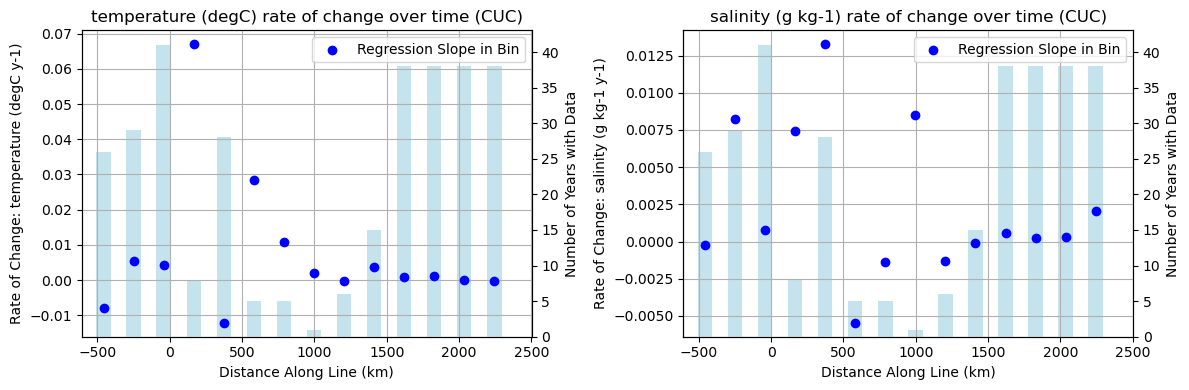

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
plot_ratediff_NS('temperature (degC)', 'CUC', 0)
plot_ratediff_NS('salinity (g kg-1)', 'CUC', 1)
plt.tight_layout()

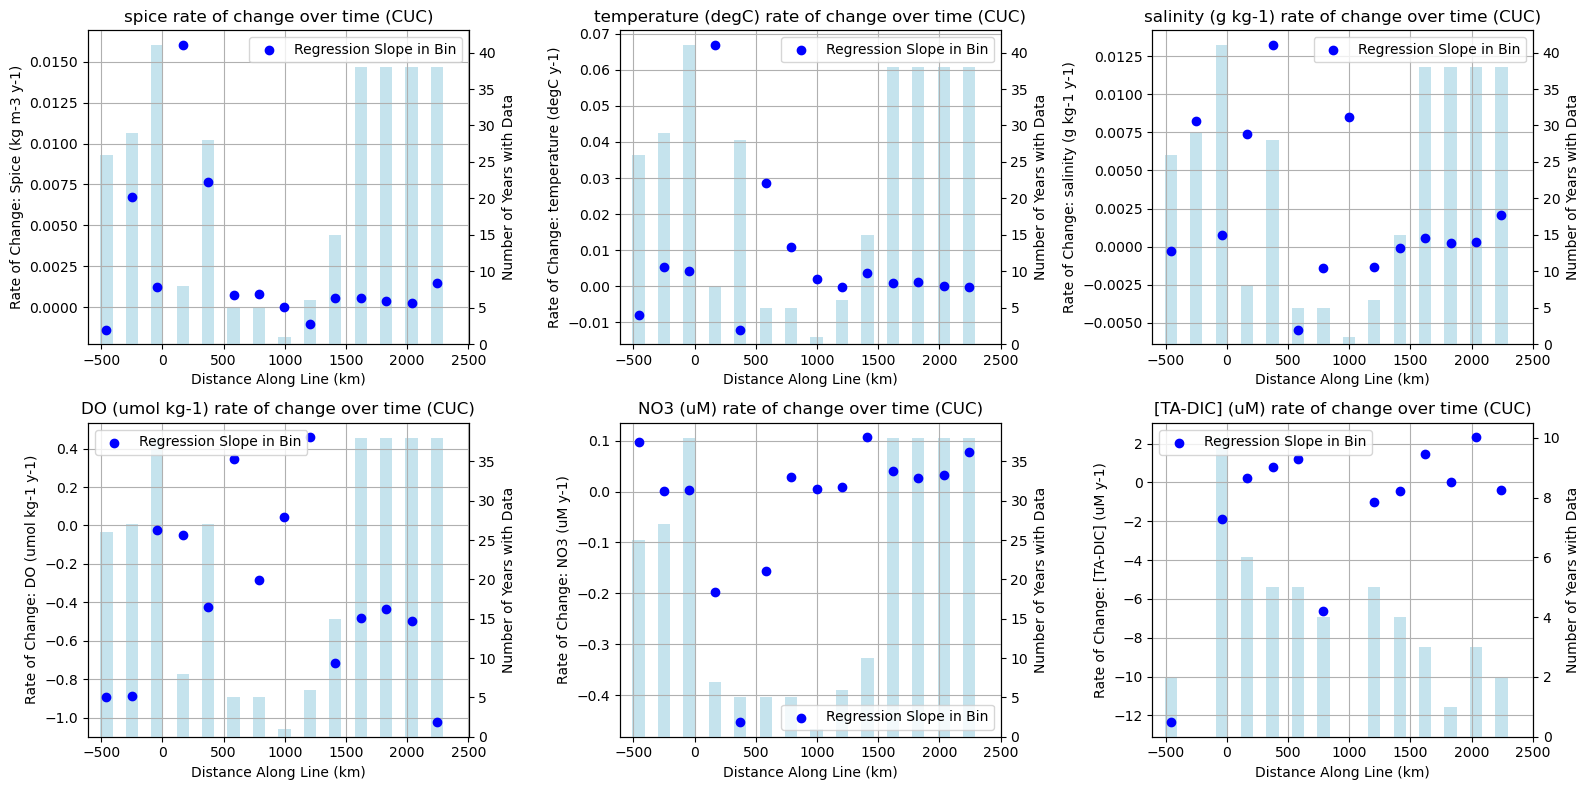

In [8]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
plot_ratediff_NS('spice', 'CUC', (0,0))
plot_ratediff_NS('temperature (degC)', 'CUC', (0,1))
plot_ratediff_NS('salinity (g kg-1)', 'CUC', (0,2))
plot_ratediff_NS('DO (umol kg-1)', 'CUC', (1,0))
plot_ratediff_NS('NO3 (uM)', 'CUC', (1,1))
plot_ratediff_NS('[TA-DIC] (uM)', 'CUC', (1,2))
plt.tight_layout()

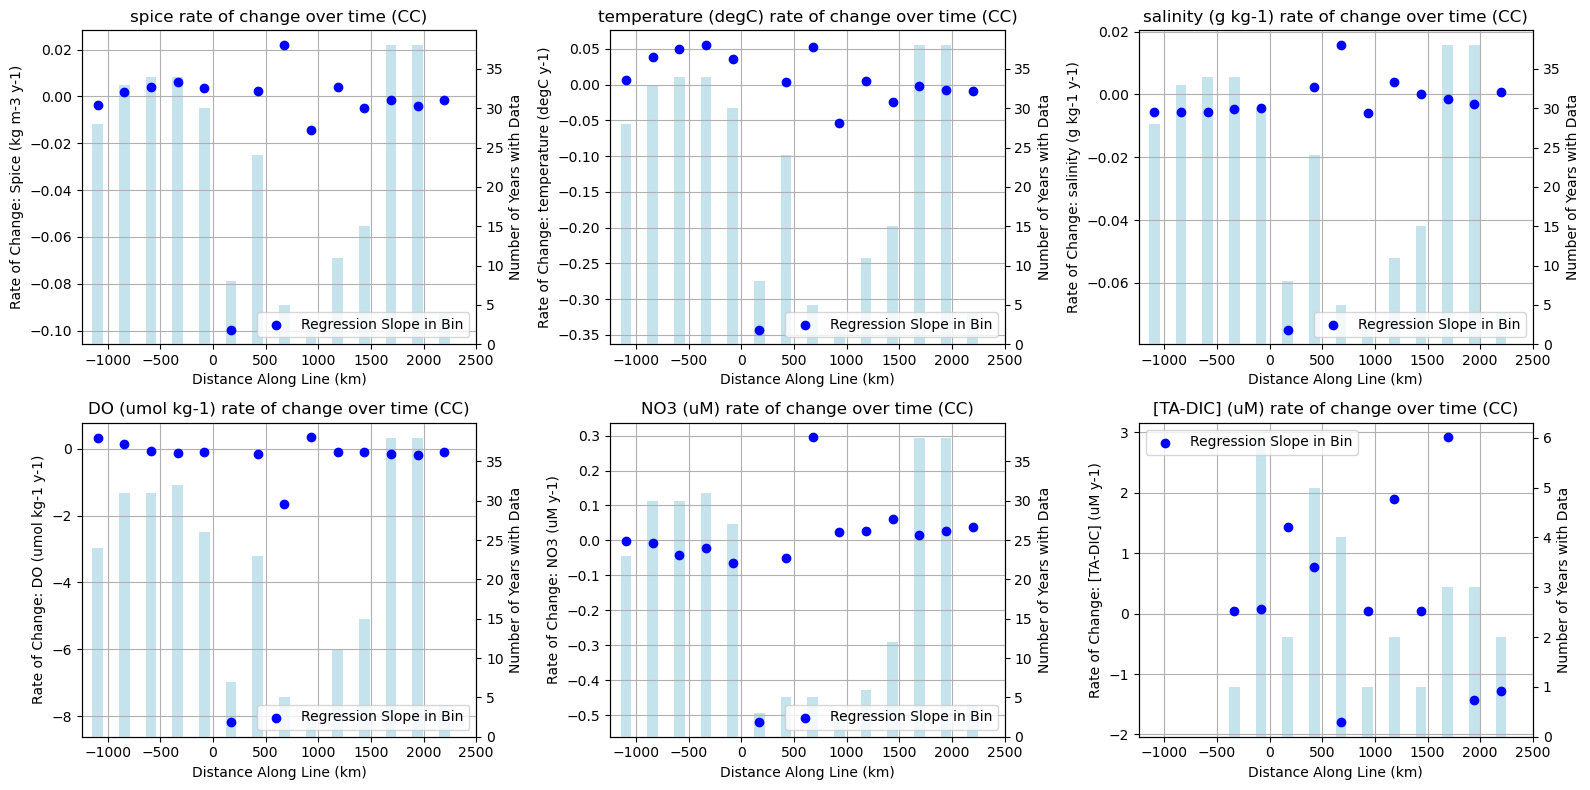

In [9]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
plot_ratediff_NS('spice', 'CC', (0,0))
plot_ratediff_NS('temperature (degC)', 'CC', (0,1))
plot_ratediff_NS('salinity (g kg-1)', 'CC', (0,2))
plot_ratediff_NS('DO (umol kg-1)', 'CC', (1,0))
plot_ratediff_NS('NO3 (uM)', 'CC', (1,1))
plot_ratediff_NS('[TA-DIC] (uM)', 'CC', (1,2))
plt.tight_layout()

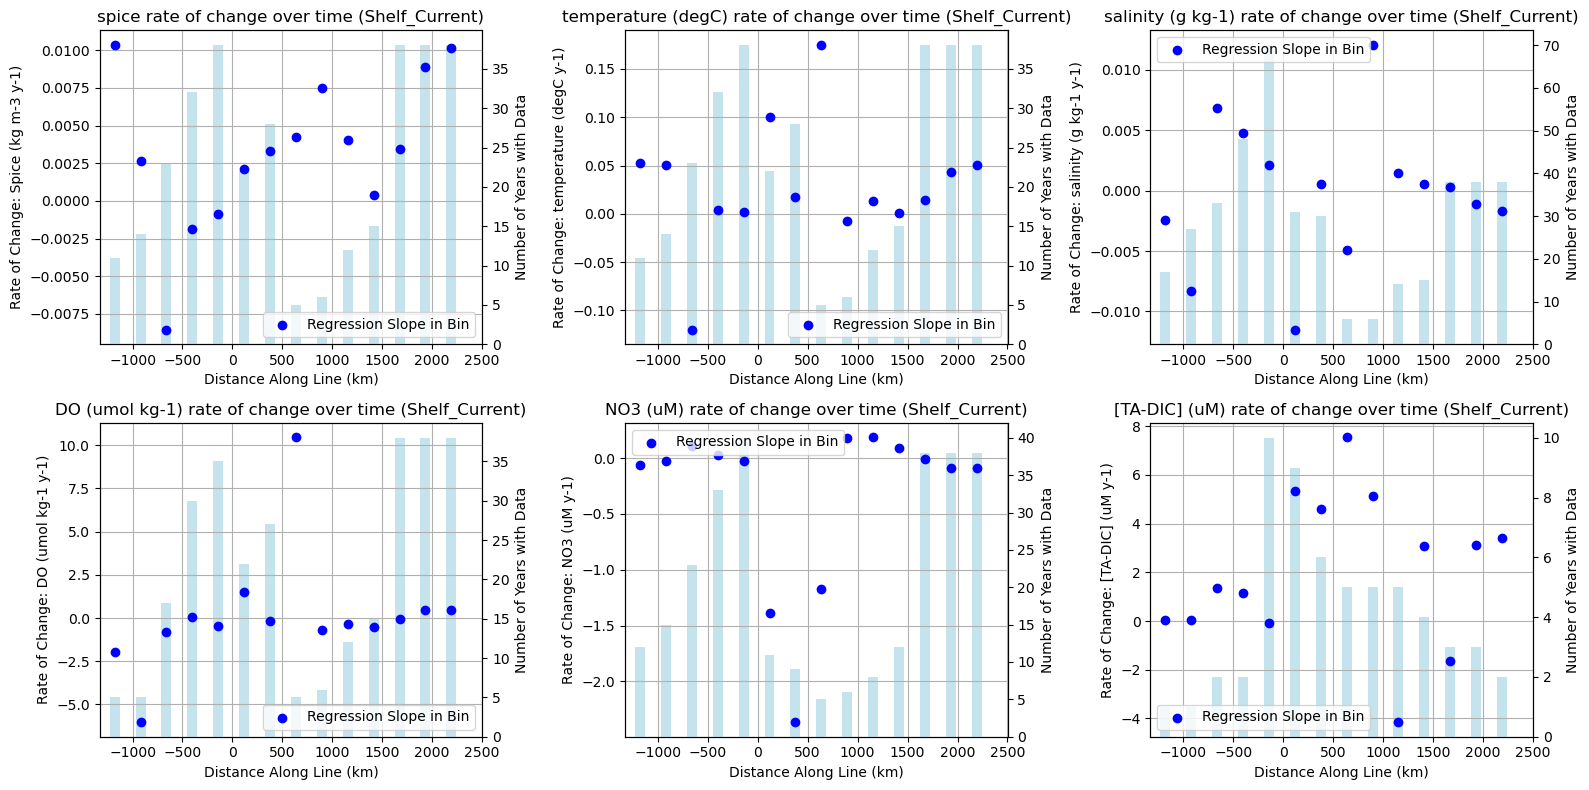

In [10]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
plot_ratediff_NS('spice', 'Shelf_Current', (0,0))
plot_ratediff_NS('temperature (degC)', 'Shelf_Current', (0,1))
plot_ratediff_NS('salinity (g kg-1)', 'Shelf_Current', (0,2))
plot_ratediff_NS('DO (umol kg-1)', 'Shelf_Current', (1,0))
plot_ratediff_NS('NO3 (uM)', 'Shelf_Current', (1,1))
plot_ratediff_NS('[TA-DIC] (uM)', 'Shelf_Current', (1,2))
plt.tight_layout()

In [11]:
def plot_ratediff_NS_CI(var_string, current_string, subplot_pos):

    if current_string=='CUC':
        obs_used = obs_cuc
    elif current_string=='Shelf_Current':
        obs_used = obs_shelf
    elif current_string=='CC':
        obs_used = obs_cc
    else:
        raise Exception("Invalid Current Name") 
    # Set ylims so they are consistent across currents
    ylim_dict = {'spice':[-0.015,0.02], 'temperature (degC)': [-0.1,0.2], 'salinity (g kg-1)':[-0.02,0.015], 'DO (umol kg-1)':[-4,12.5], 'NO3 (uM)':[-3,1.5], '[TA-DIC] (uM)':[-7.5,22]}
    
    max_NS = max(obs_used['dist'])
    min_NS = min(obs_used['dist'])
    
    rates_NS_binned = []
    coeff_list = []
    upper_CI = []
    lower_CI = []
    num_yrs = []
    bins_NS = np.linspace(min_NS, max_NS, num=10)
    for i in range(len(bins_NS)-1):
        low_bound = bins_NS[i]
        high_bound = bins_NS[i+1]
    
        obs_bin = obs_used[(obs_used['dist'] <= high_bound) & (obs_used['dist'] >= low_bound)]
        
        x = obs_bin['year']
        y = obs_bin[var_string]
        
        idx = ~np.isnan(x) & ~np.isnan(y)
        # m, b = np.polyfit(x[idx], y[idx], 1)
        # print(x[idx])

        if sum(idx) == 0:
            rates_NS_binned += [np.nan]
            num_yrs += [0]
            lower_CI += [np.nan]
            upper_CI += [np.nan]
            continue

        X = x[idx]
        Y = y[idx] 
        num_yrs += [len(set(X))]
            
        # Calculate weights based on the inverse of the variance of the errors
        errors = Y - np.mean(Y)
        error_variance = np.var(errors)
            
        if error_variance==0:
            weights=1
        else:
            weights = 1 / error_variance
            
        # Fit weighted least squares regression model
        X = sm.add_constant(X)
        model = sm.WLS(Y, X, weights=weights)
        results = model.fit()
            
        # Print regression results
        # print(results.summary())

        r = results.rsquared    # rsquared parameter

        try:
            m = results.params[1]   # slope of regression
        except:
            m = results.params[0] 

        # Default 95% CI
        ci = results.conf_int(alpha=0.05)  # alpha = 1 - confidence level
        # Named access
        ci.columns = ["lower", "upper"]

        if 'year' in ci.index:
                slope_ci = ci.loc['year']
        else:
            # Key does not exist
            print("Column 'const' is missing.")
            slope_ci = [np.nan, np.nan]

        lower_CI += [slope_ci[0]]
        upper_CI += [slope_ci[1]]

        if m==0:
            rates_NS_binned += [np.nan]
        else:
            rates_NS_binned += [m]

    
    rates_NS_binned = np.array(rates_NS_binned)

    ax2 = ax[subplot_pos].twinx()

    # return bins_NS, num_yrs, rates_NS_binned
   
    ax2.bar(bins_NS[:-1], num_yrs, width=130, label='N', color='lightblue', alpha=0.7, zorder=3)
    ax2.set_ylabel('Number of Years in Regression')
    
    # ax[subplot_pos].scatter(bins_NS[:-1], rates_NS_binned, label='Regression Slope in Bin', color='b', s=0.5, zorder=5)
    # ax[subplot_pos].fill_between(bins_NS[:-1], upper_CI, lower_CI)
    
    yerr = [upper_CI-rates_NS_binned, rates_NS_binned-lower_CI]
    ax[subplot_pos].errorbar(bins_NS[:-1], rates_NS_binned, yerr=yerr, fmt='.', ms=7, c='darkblue', label='95% CI')
    
    ax[subplot_pos].set_xlim([min(bins_NS)-150, max(bins_NS)+50])
    ax[subplot_pos].set_xlabel('Distance Along Line (km)')
    if var_string == 'spice':
        ax[subplot_pos].set_ylabel('Rate of Change: Spice (kg m-3 y-1)')
    else:
        ax[subplot_pos].set_ylabel("Rate of Change: " + var_string[:-1] + ' y-1' + var_string[-1:])
    
    ax[subplot_pos].set_title(f'{var_string} rate of change over time ({current_string})')
    ax[subplot_pos].grid()
    ax[subplot_pos].legend()
    ax[subplot_pos].axhline(y=0, color='black', linewidth=1, linestyle='-', zorder=2)
    
    if var_string in list(ylim_dict.keys()):
        ax[subplot_pos].set_ylim(ylim_dict[var_string])
    
    ax2.set_zorder(1)
    ax[subplot_pos].set_zorder(3)
    ax[subplot_pos].patch.set_alpha(0)

    return None

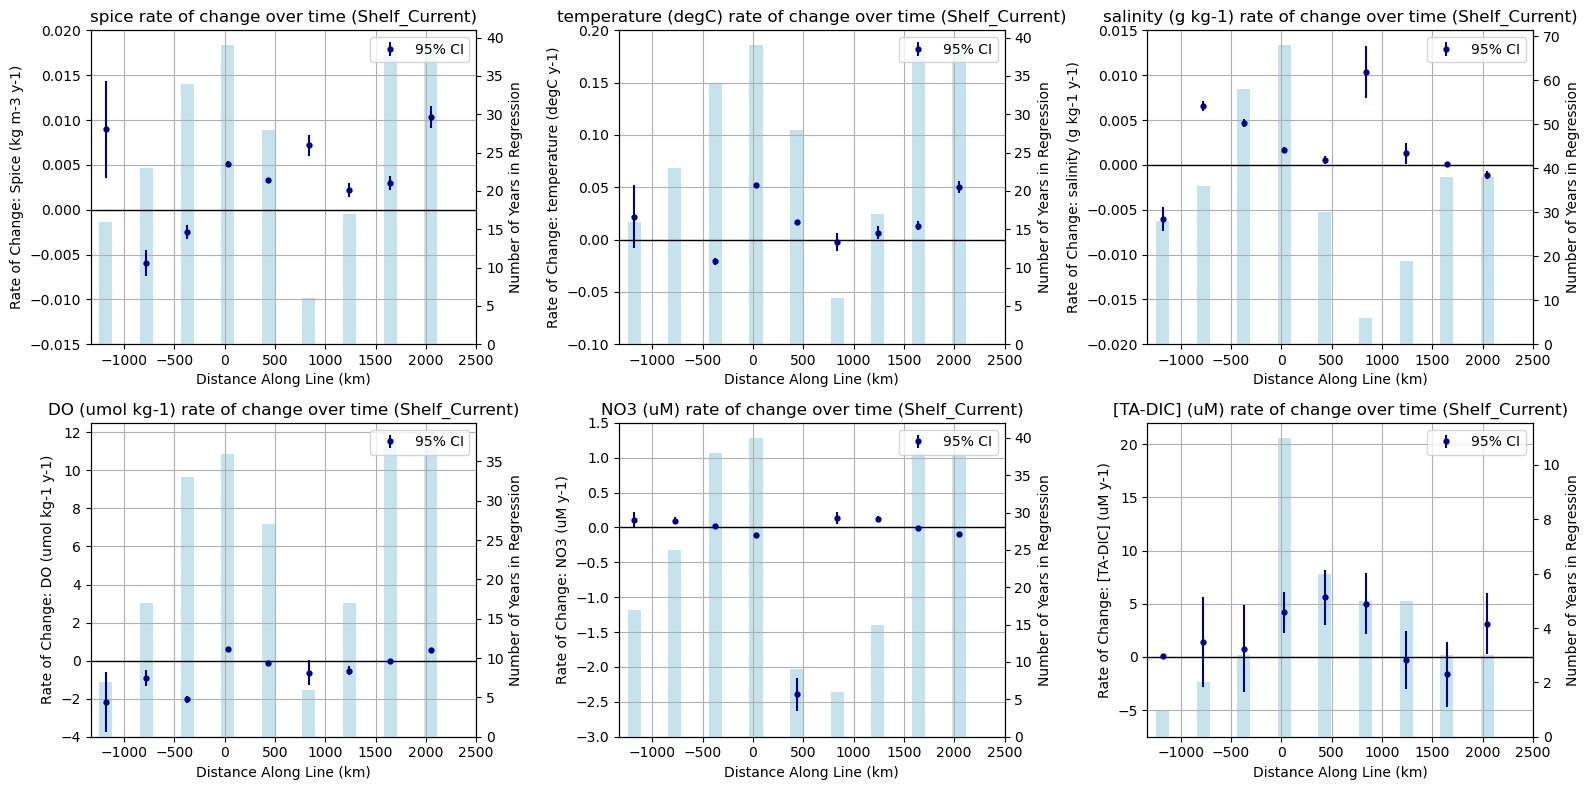

In [12]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
plot_ratediff_NS_CI('spice', 'Shelf_Current', (0,0))
plot_ratediff_NS_CI('temperature (degC)', 'Shelf_Current', (0,1))
plot_ratediff_NS_CI('salinity (g kg-1)', 'Shelf_Current', (0,2))
plot_ratediff_NS_CI('DO (umol kg-1)', 'Shelf_Current', (1,0))
plot_ratediff_NS_CI('NO3 (uM)', 'Shelf_Current', (1,1))
plot_ratediff_NS_CI('[TA-DIC] (uM)', 'Shelf_Current', (1,2))
plt.tight_layout()

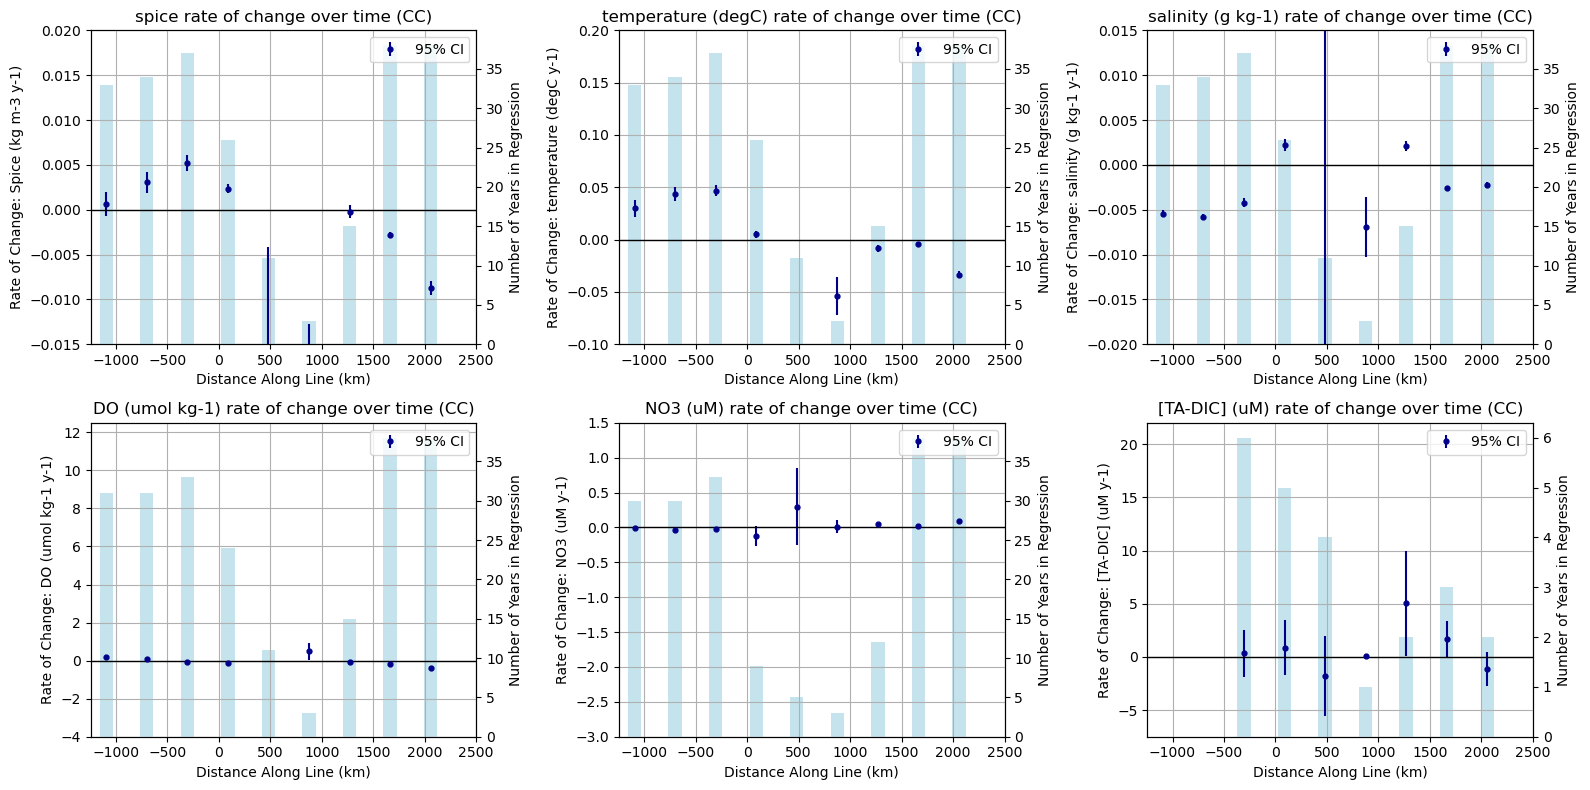

In [13]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
plot_ratediff_NS_CI('spice', 'CC', (0,0))
plot_ratediff_NS_CI('temperature (degC)', 'CC', (0,1))
plot_ratediff_NS_CI('salinity (g kg-1)', 'CC', (0,2))
plot_ratediff_NS_CI('DO (umol kg-1)', 'CC', (1,0))
plot_ratediff_NS_CI('NO3 (uM)', 'CC', (1,1))
plot_ratediff_NS_CI('[TA-DIC] (uM)', 'CC', (1,2))
plt.tight_layout()

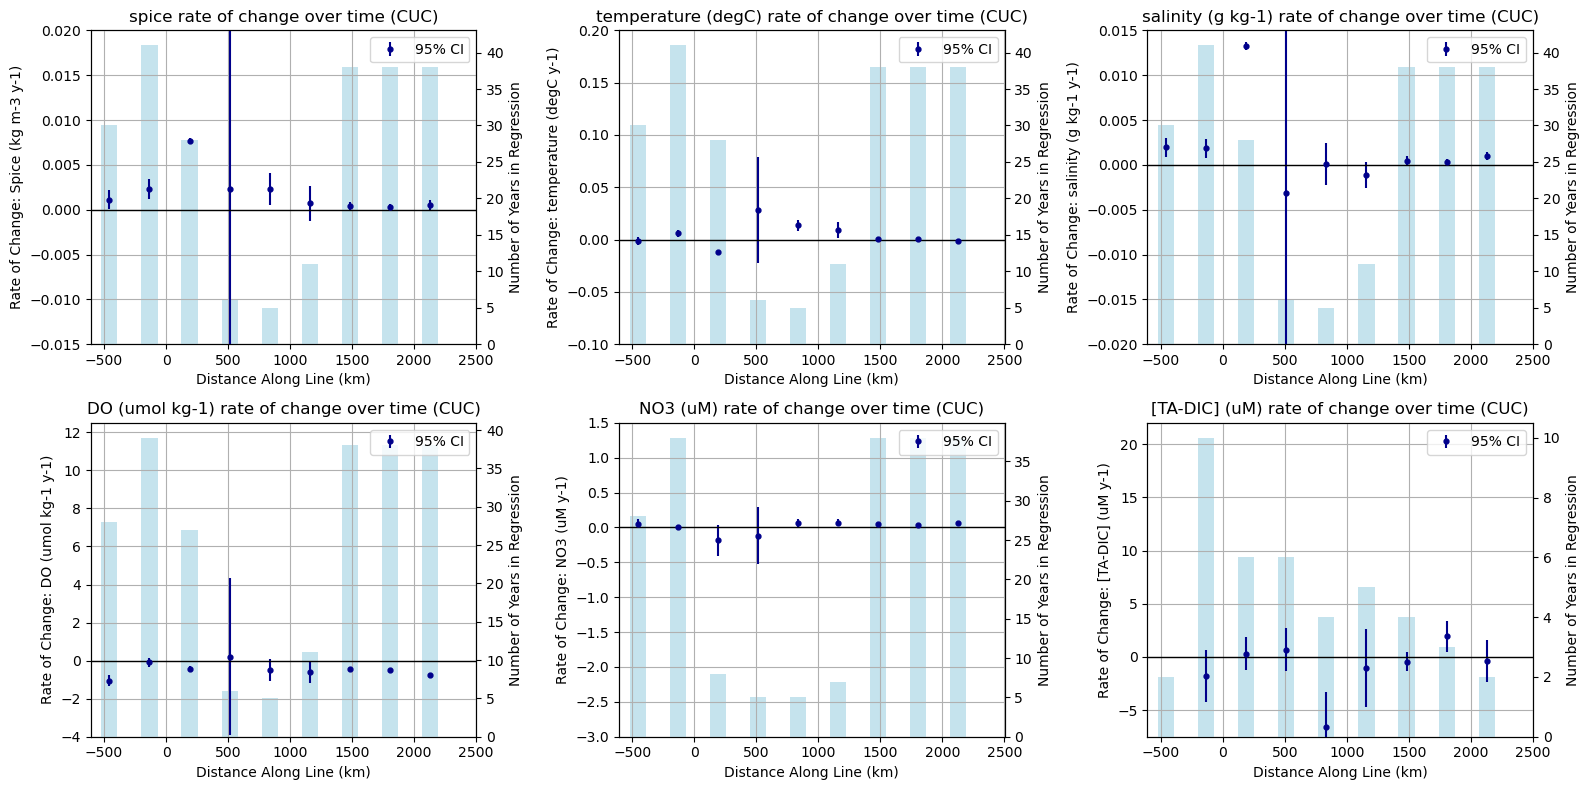

In [14]:
fig, ax = plt.subplots(2,3, figsize=(16, 8))
plot_ratediff_NS_CI('spice', 'CUC', (0,0))
plot_ratediff_NS_CI('temperature (degC)', 'CUC', (0,1))
plot_ratediff_NS_CI('salinity (g kg-1)', 'CUC', (0,2))
plot_ratediff_NS_CI('DO (umol kg-1)', 'CUC', (1,0))
plot_ratediff_NS_CI('NO3 (uM)', 'CUC', (1,1))
plot_ratediff_NS_CI('[TA-DIC] (uM)', 'CUC', (1,2))
plt.tight_layout()